In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
import statistics

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 50
batch_size = 64
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

In [0]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])
train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
def plot_graph(training_losses,val_losses,epochs,string):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.title(string + 'per epoch')
    plt.xlabel('Epoch')
    plt.ylabel(string)

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(3136, 500)
        self.fc1_drop = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)),2))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,labels)
            epoch_loss += loss.item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)



In [0]:
model = Classifier().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss, val_accuracy = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 0
Average training loss: 0.8999, Training Accuracy: 32046/48000 (67%)
Average test loss: 0.5466, Testing Accuracy: 9544/12000 (80%)
Epoch 1
Average training loss: 0.5049, Training Accuracy: 39504/48000 (82%)
Average test loss: 0.4025, Testing Accuracy: 10328/12000 (86%)
Epoch 2
Average training loss: 0.4200, Training Accuracy: 41124/48000 (86%)
Average test loss: 0.3682, Testing Accuracy: 10440/12000 (87%)
Epoch 3
Average training loss: 0.3810, Training Accuracy: 41702/48000 (87%)
Average test loss: 0.3229, Testing Accuracy: 10658/12000 (89%)
Epoch 4
Average training loss: 0.3606, Training Accuracy: 42138/48000 (88%)
Average test loss: 0.3166, Testing Accuracy: 10651/12000 (89%)
Epoch 5
Average training loss: 0.3395, Training Accuracy: 42486/48000 (89%)
Average test loss: 0.2939, Testing Accuracy: 10731/12000 (89%)
Epoch 6
Average training loss: 0.3341, Training Accuracy: 42447/48000 (88%)
Average test loss: 0.3061, Testing Accuracy: 10691/12000 (89%)
Epoch 7
Average training los

Average test loss: 0.4107, Testing Accuracy: 8956/10000 (90%)
Lowest validation loss 0.2854970156987931
Lowest training loss 0.24985185649991035


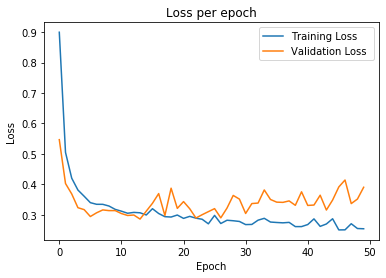

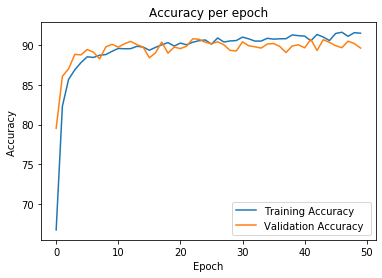

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
test(model,device,testloader,criterion)
print("Lowest validation loss", min(val_losses))
print("Lowest training loss", min(training_losses))

# Autoencoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,images)
            epoch_loss += loss.item()
    epoch_loss /= len(testloader)
    print('Average testing loss: {:.4f}'.format(epoch_loss))
    return epoch_loss



In [0]:
model = AutoEncoder().to(device)
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 0
Average training loss: 0.006296020150495072
Average testing loss: 0.0056
Epoch 1
Average training loss: 0.0035626831389963627
Average testing loss: 0.0033
Epoch 2
Average training loss: 0.00308493601779143
Average testing loss: 0.0030
Epoch 3
Average training loss: 0.002859299168922007
Average testing loss: 0.0027
Epoch 4
Average training loss: 0.0027436268359112242
Average testing loss: 0.0028
Epoch 5
Average training loss: 0.002638843037808935
Average testing loss: 0.0024
Epoch 6
Average training loss: 0.0025273626662480333
Average testing loss: 0.0024
Epoch 7
Average training loss: 0.002460920855247726
Average testing loss: 0.0024
Epoch 8
Average training loss: 0.002449336954392493
Average testing loss: 0.0024
Epoch 9
Average training loss: 0.0023839193624444308
Average testing loss: 0.0024
Epoch 10
Average training loss: 0.0023842222248204054
Average testing loss: 0.0025
Epoch 11
Average training loss: 0.002285936968711515
Average testing loss: 0.0023
Epoch 12
Average train

Average testing loss: 0.0019
Lowest validation loss 0.0018472247967555961


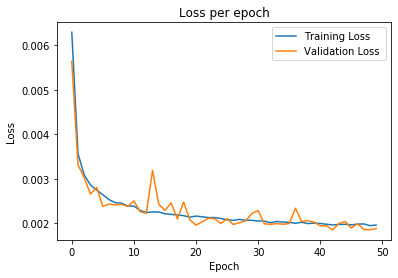

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
test(model,device,testloader,criterion)
print("Lowest validation loss", min(val_losses))

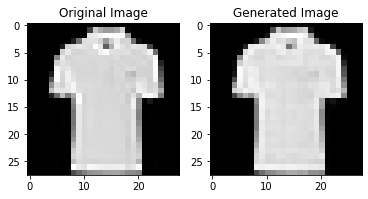

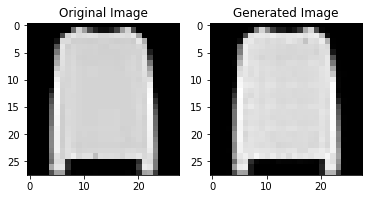

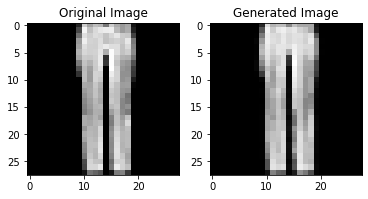

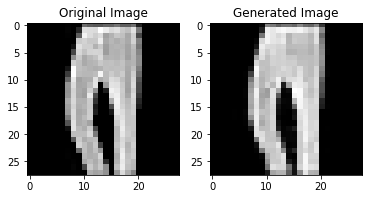

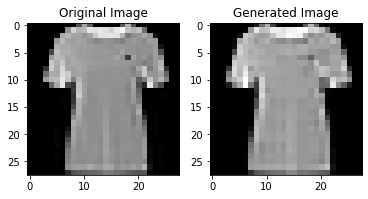

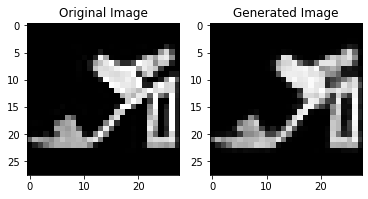

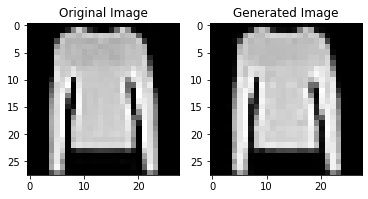

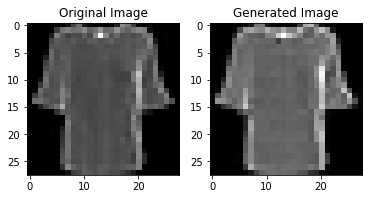

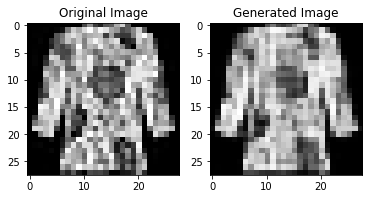

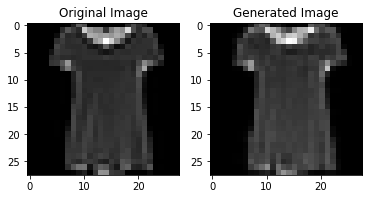

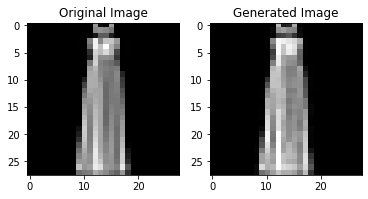

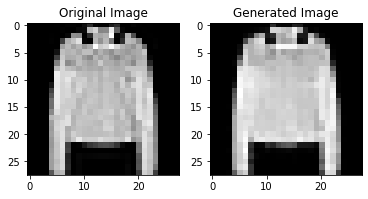

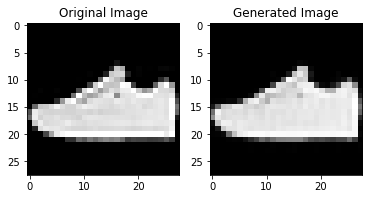

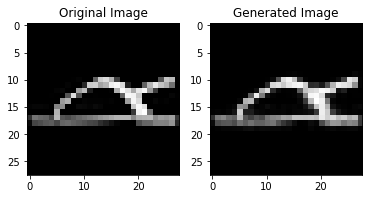

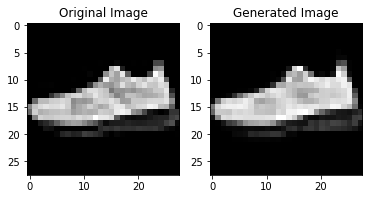

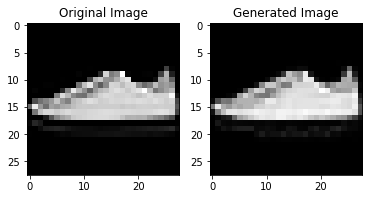

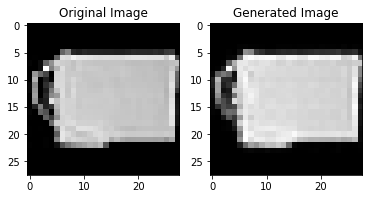

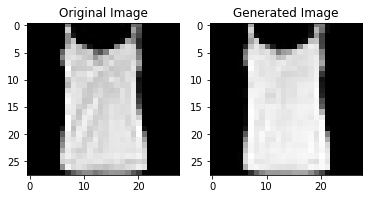

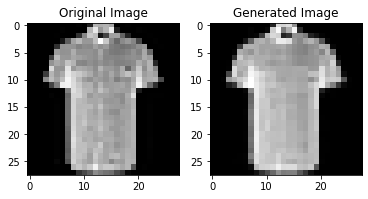

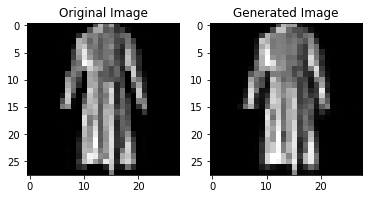

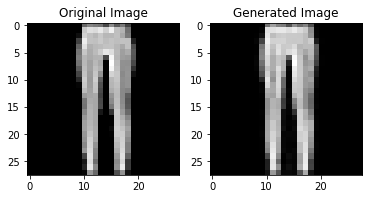

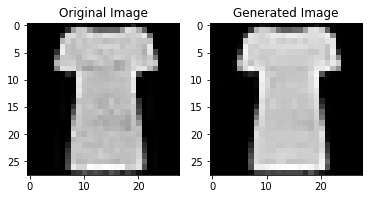

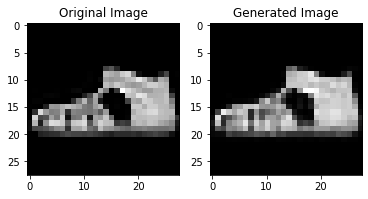

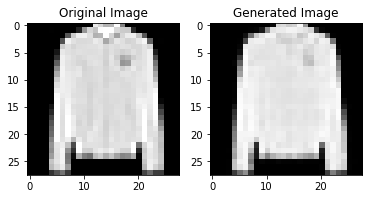

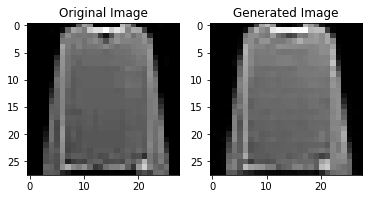

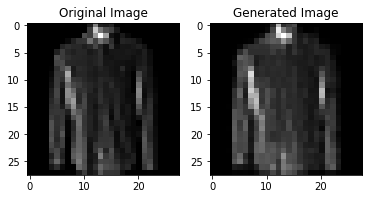

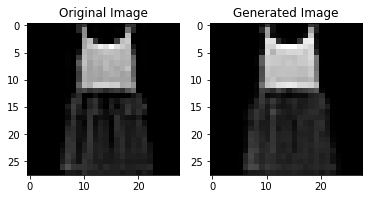

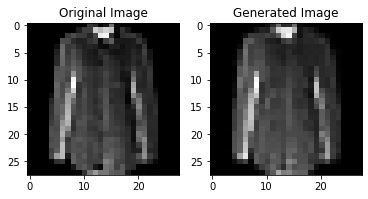

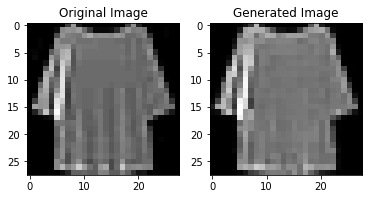

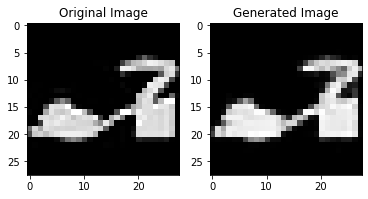

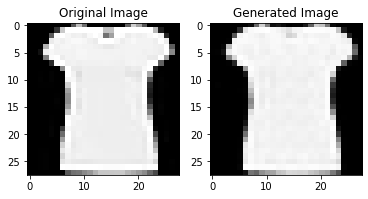

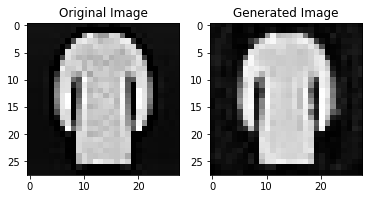

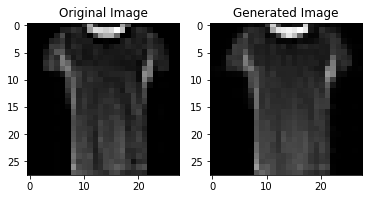

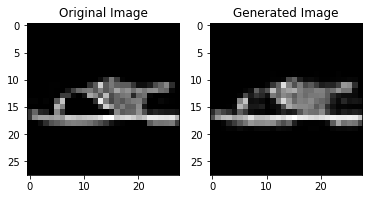

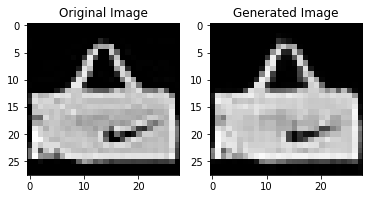

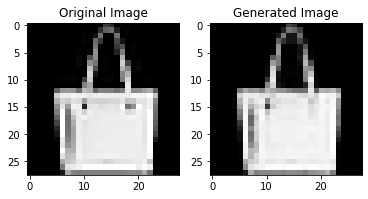

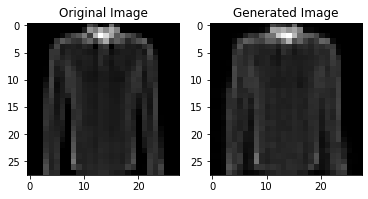

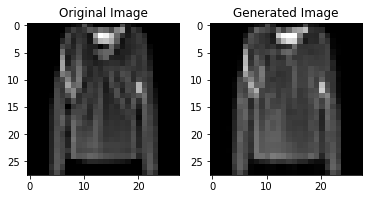

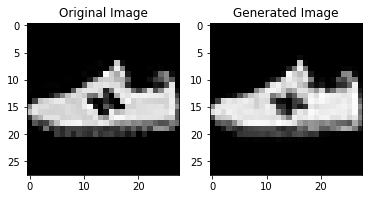

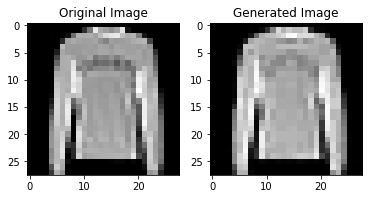

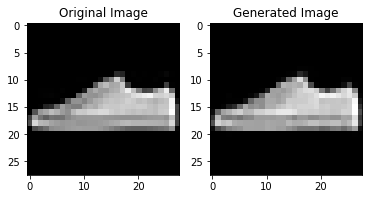

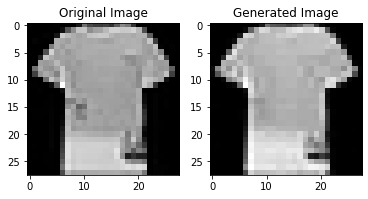

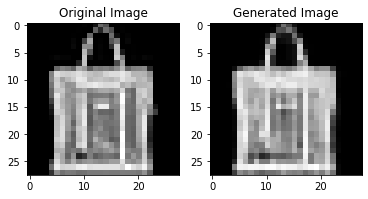

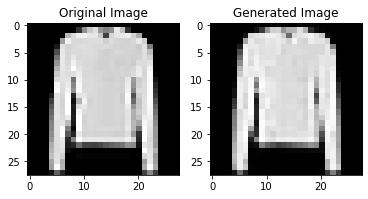

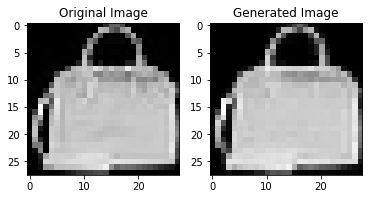

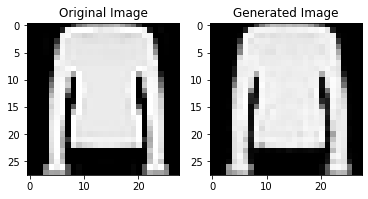

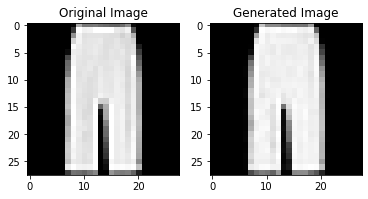

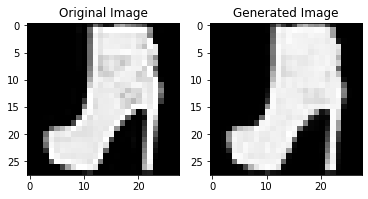

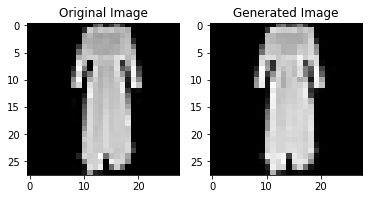

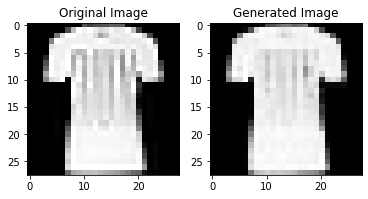

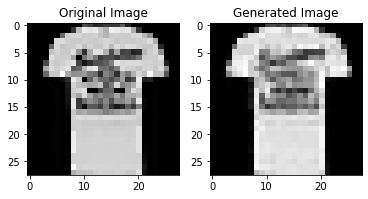

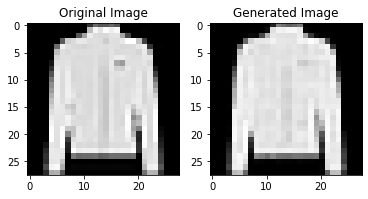

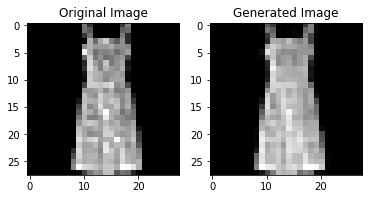

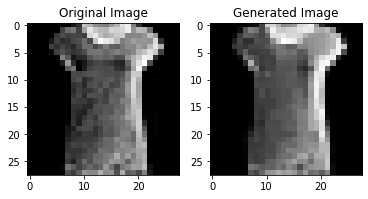

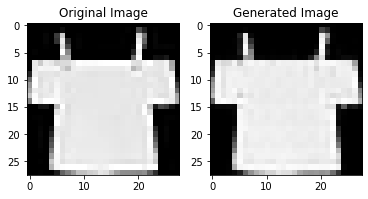

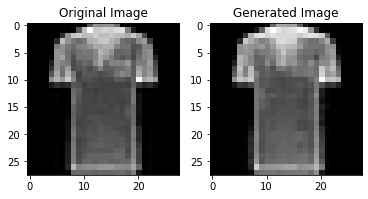

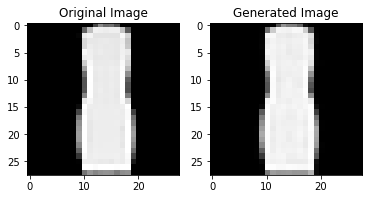

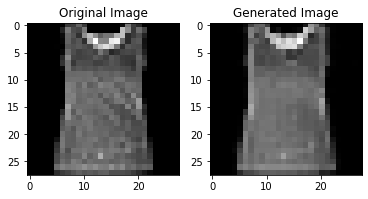

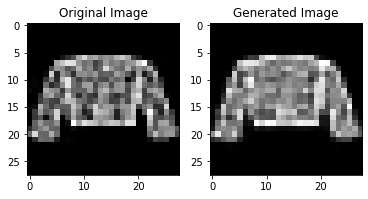

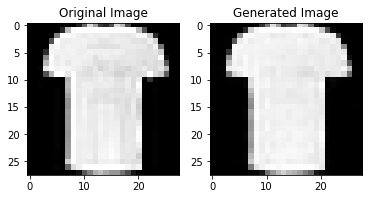

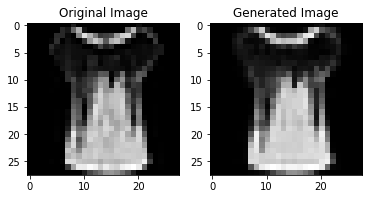

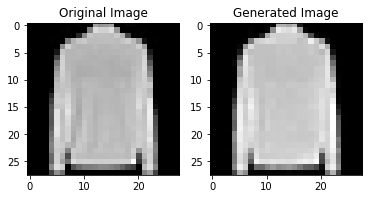

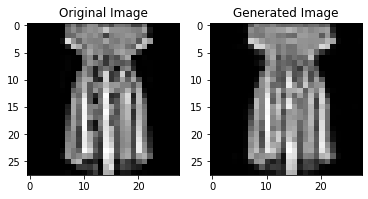

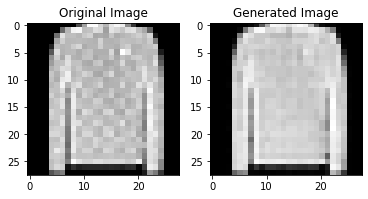

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed model definitions

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(3136,500),
            nn.Dropout(p=0.3),
            nn.ReLU(),
  
            nn.Linear(500,50),
            nn.Dropout(p=0.3),
            nn.ReLU(),

            nn.Linear(50,10),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted

# Mixed (autoencoder loss)

In [0]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss = criterion1(decoded,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss = criterion1(decoded,images)
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss

In [0]:
model1 = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss = train(model,device,optimizer,epoch,trainloader)
    val_loss = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 0.005762075339443982
Average loss: 0.0035, Testing Accuracy: 784/12000 (7%)
Epoch 1
Average training loss: 0.003199272210088869
Average loss: 0.0031, Testing Accuracy: 901/12000 (8%)
Epoch 2
Average training loss: 0.0028255777531303464
Average loss: 0.0029, Testing Accuracy: 957/12000 (8%)
Epoch 3
Average training loss: 0.0026321923499926926
Average loss: 0.0026, Testing Accuracy: 1063/12000 (9%)
Epoch 4
Average training loss: 0.0024872840029808384
Average loss: 0.0051, Testing Accuracy: 1004/12000 (8%)
Epoch 5
Average training loss: 0.0024199226365114253
Average loss: 0.0035, Testing Accuracy: 1048/12000 (9%)
Epoch 6
Average training loss: 0.0023526938531237343
Average loss: 0.0031, Testing Accuracy: 1116/12000 (9%)
Epoch 7
Average training loss: 0.0023085561118399104
Average loss: 0.0022, Testing Accuracy: 1113/12000 (9%)
Epoch 8
Average training loss: 0.0022501491798708837
Average loss: 0.0026, Testing Accuracy: 1177/12000 (10%)
Epoch 9
Average training loss: 

In [0]:
train_mean_auto = statistics.mean(training_losses)
val_mean_auto = statistics.mean(val_losses)
train_std_auto = statistics.stdev(training_losses)
val_std_auto = statistics.stdev(val_losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average loss: 0.0020, Testing Accuracy: 1062/10000 (11%)
Lowest validation loss 0.0017431633357463919


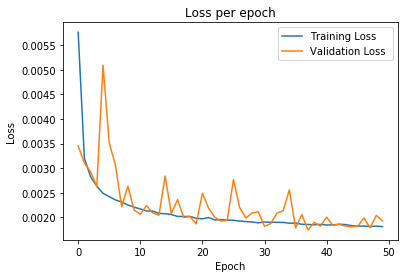

In [0]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
test(model,device,testloader)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


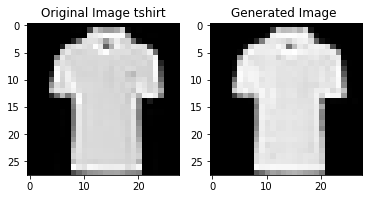

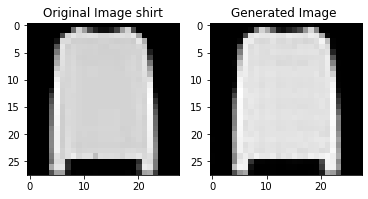

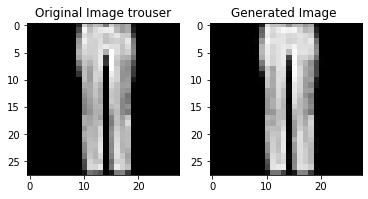

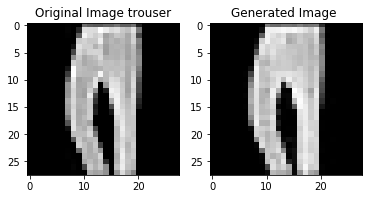

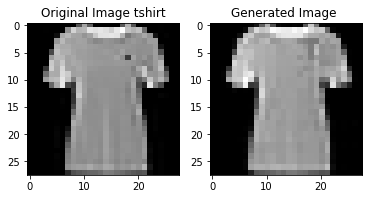

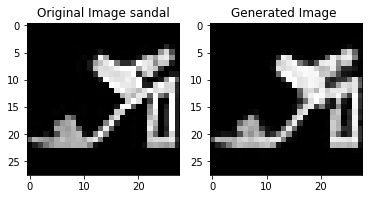

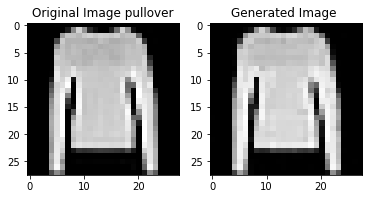

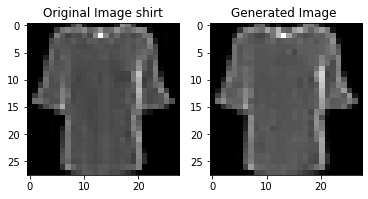

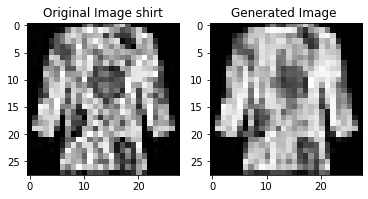

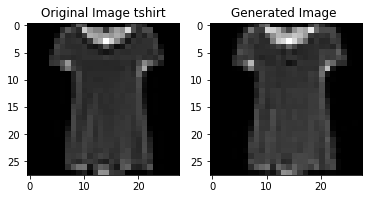

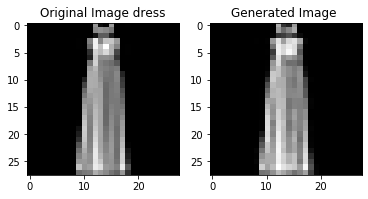

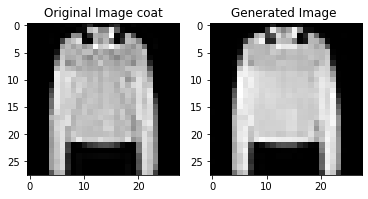

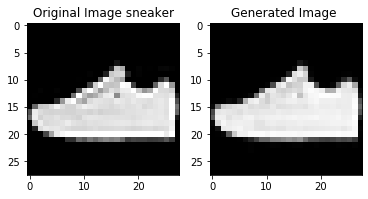

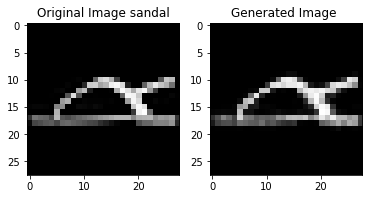

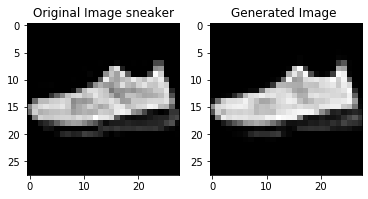

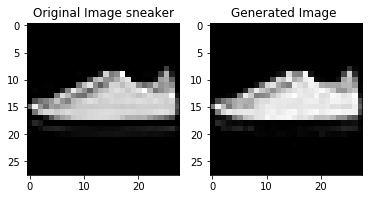

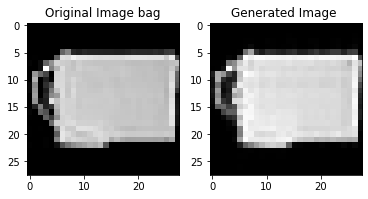

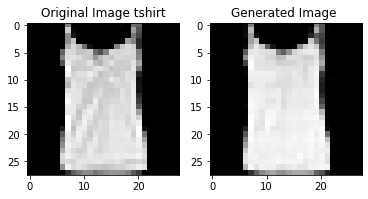

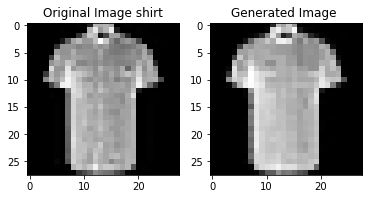

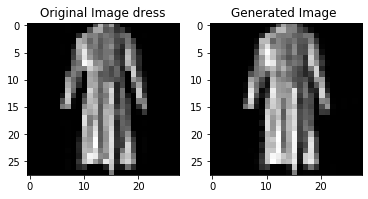

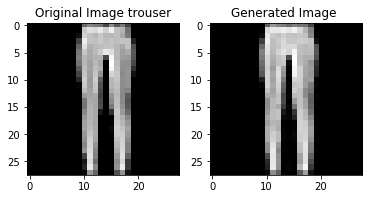

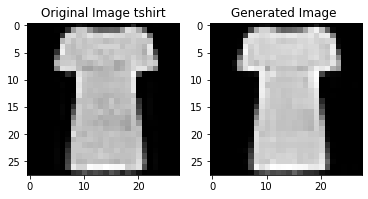

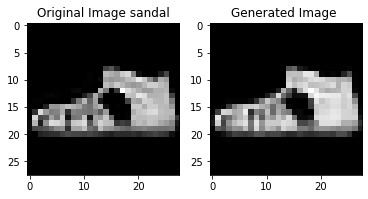

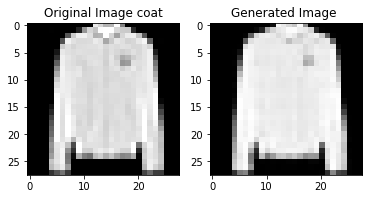

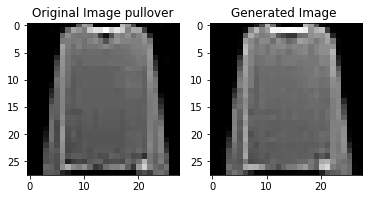

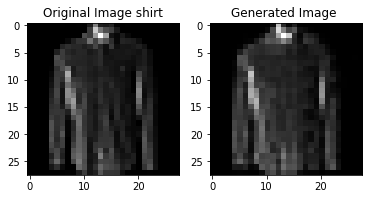

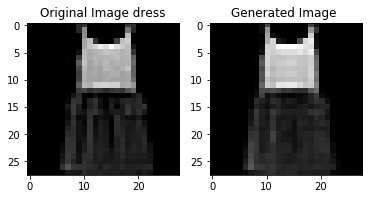

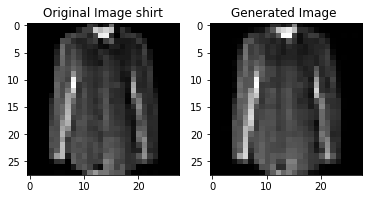

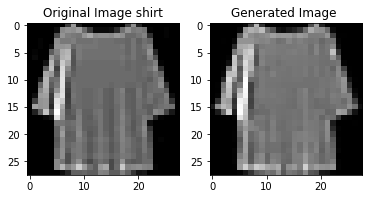

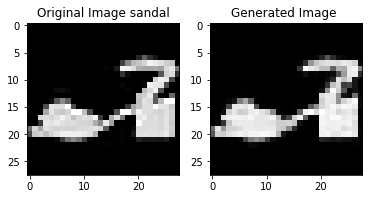

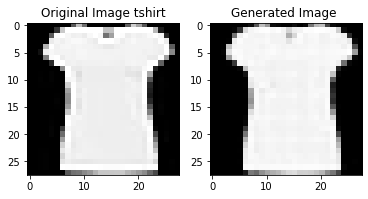

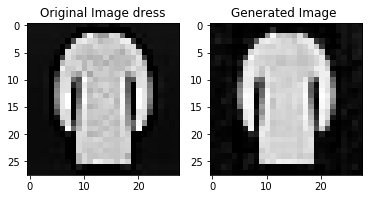

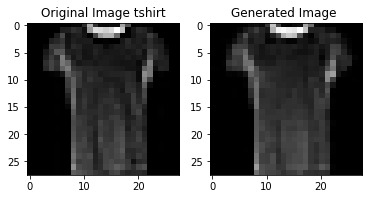

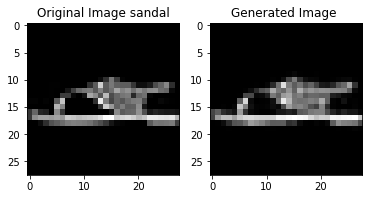

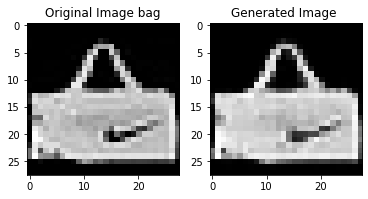

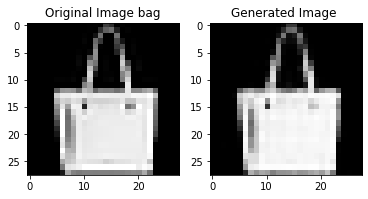

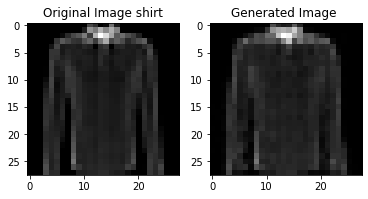

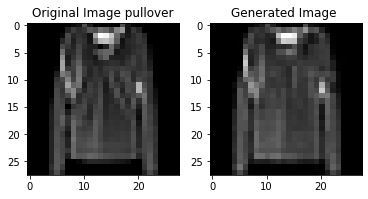

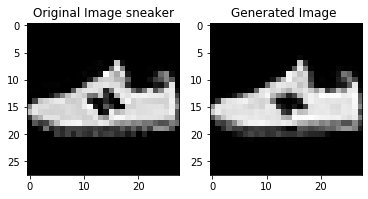

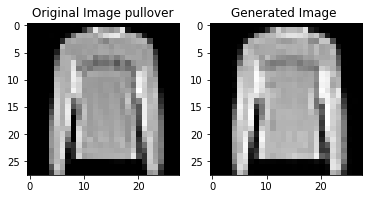

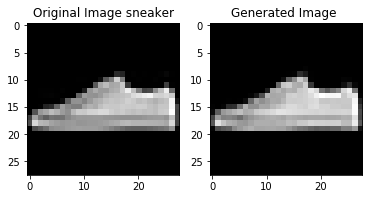

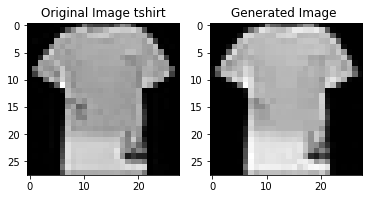

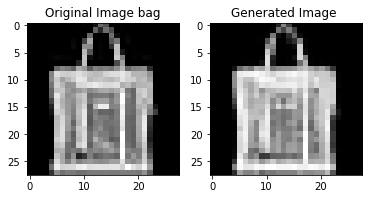

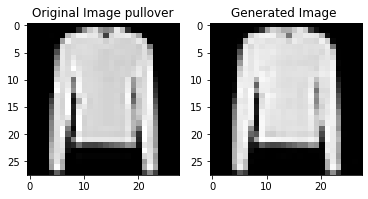

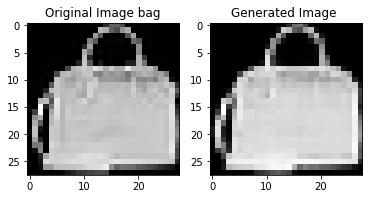

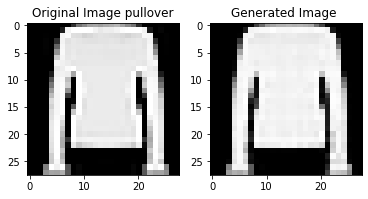

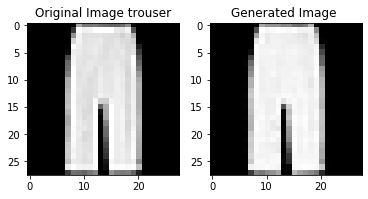

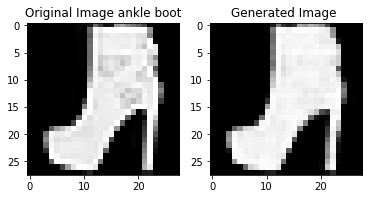

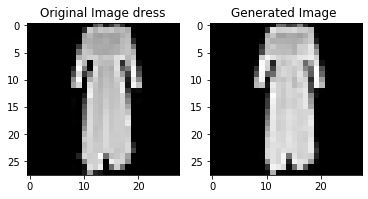

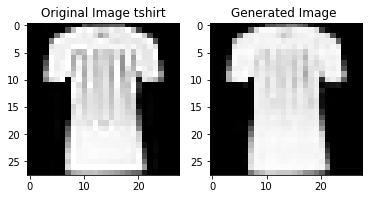

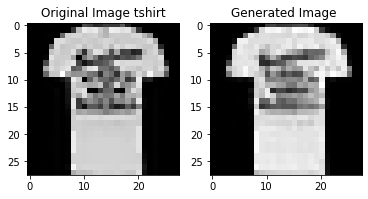

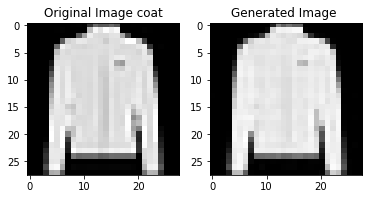

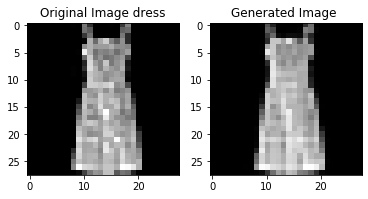

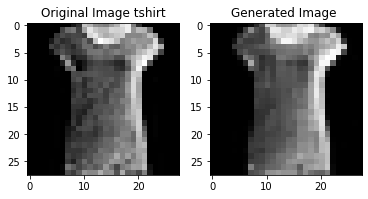

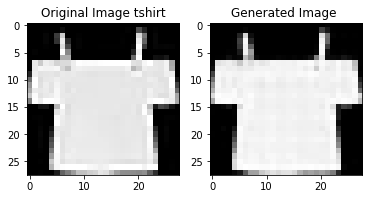

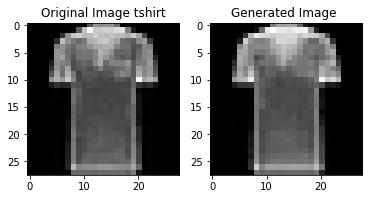

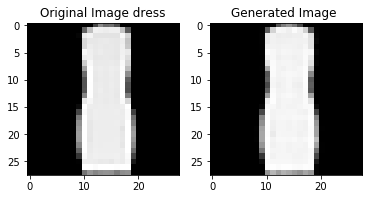

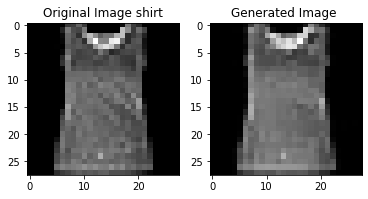

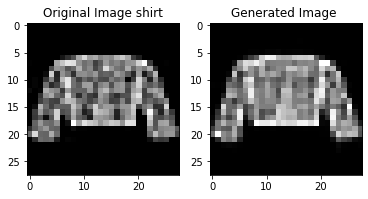

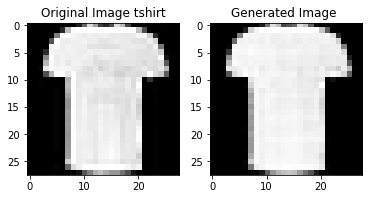

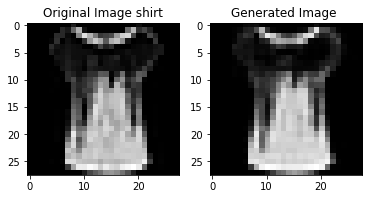

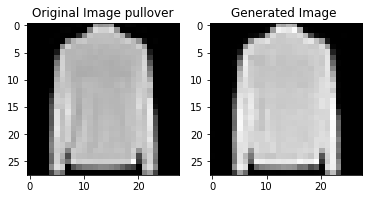

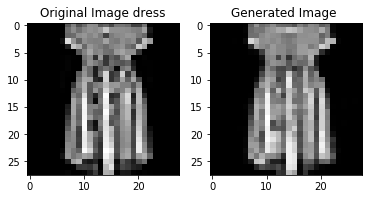

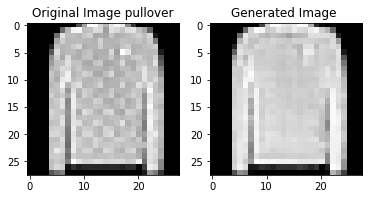

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed (classifier loss)

In [0]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss = criterion2(predicted,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss = criterion2(predicted,labels)
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average testing loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader)
    val_loss, val_accuracy = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 0.7475, Training Accuracy: 34731/48000 (72%)
Average testing loss: 0.5100, Testing Accuracy: 9799/12000 (82%)
Epoch 1
Average training loss: 0.5298, Training Accuracy: 39139/48000 (82%)
Average testing loss: 0.4037, Testing Accuracy: 10361/12000 (86%)
Epoch 2
Average training loss: 0.5315, Training Accuracy: 39489/48000 (82%)
Average testing loss: 0.3907, Testing Accuracy: 10344/12000 (86%)
Epoch 3
Average training loss: 0.4825, Training Accuracy: 40219/48000 (84%)
Average testing loss: 0.3724, Testing Accuracy: 10441/12000 (87%)
Epoch 4
Average training loss: 0.4734, Training Accuracy: 40579/48000 (85%)
Average testing loss: 0.3790, Testing Accuracy: 10459/12000 (87%)
Epoch 5
Average training loss: 0.5044, Training Accuracy: 40273/48000 (84%)
Average testing loss: 0.4088, Testing Accuracy: 10460/12000 (87%)
Epoch 6
Average training loss: 0.4792, Training Accuracy: 40553/48000 (84%)
Average testing loss: 0.3732, Testing Accuracy: 10582/12000 (88%)
Epoch 7
Average

In [0]:
train_class_mean = statistics.mean(training_losses)
val_class_mean = statistics.mean(val_losses)
train_class_std = statistics.stdev(training_losses)
val_class_std = statistics.stdev(val_losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average testing loss: 0.6720, Testing Accuracy: 8807/10000 (88%)
Lowest validation loss 0.35047035002486504


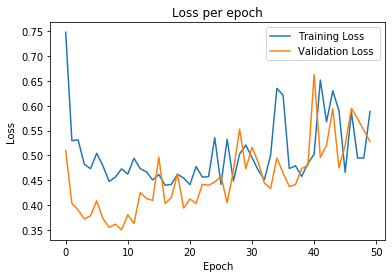

In [0]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
test(model,device,testloader)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


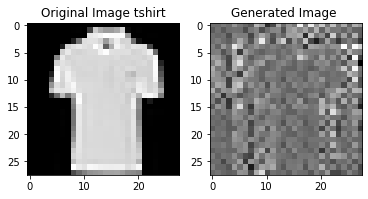

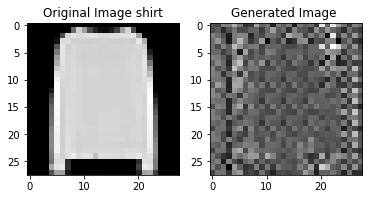

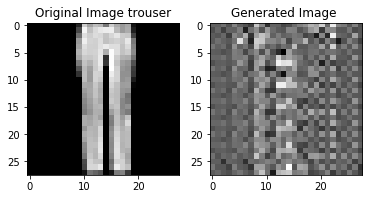

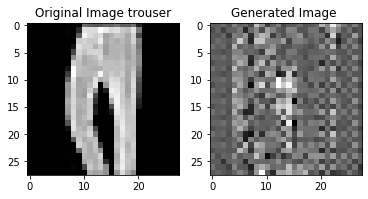

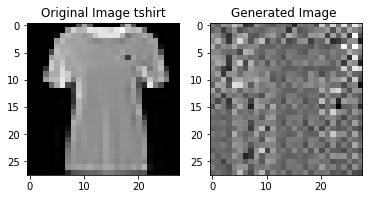

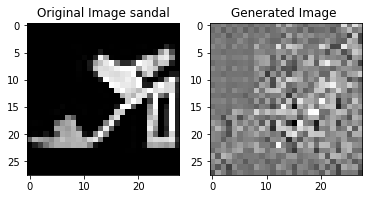

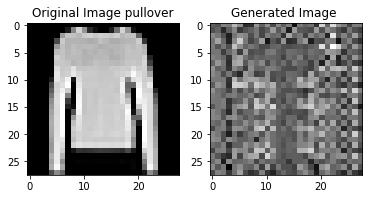

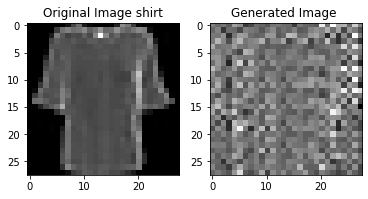

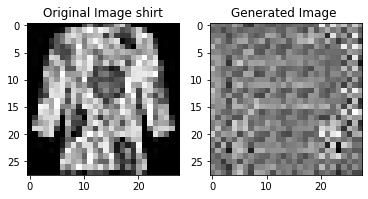

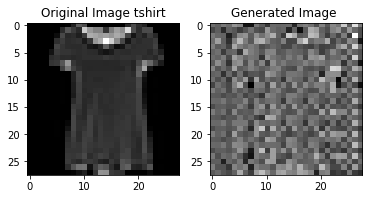

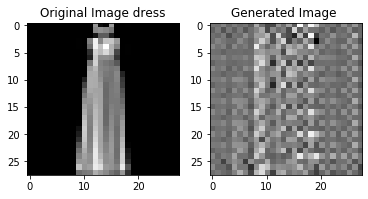

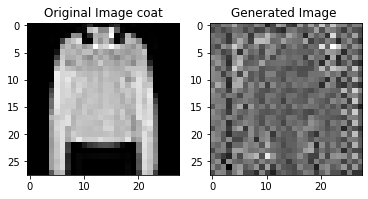

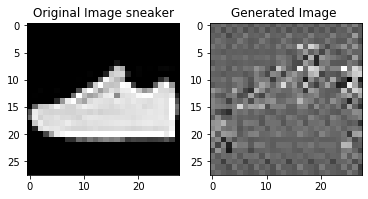

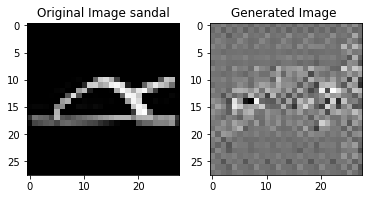

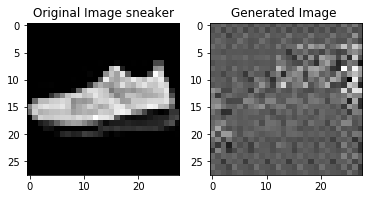

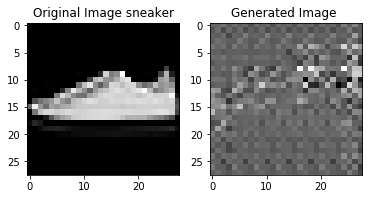

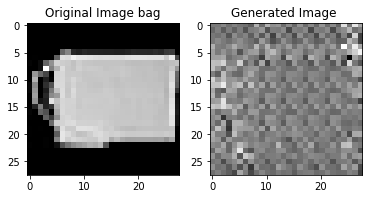

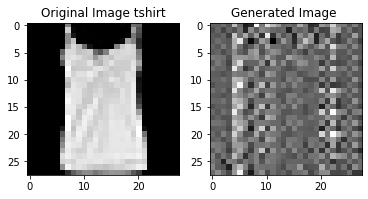

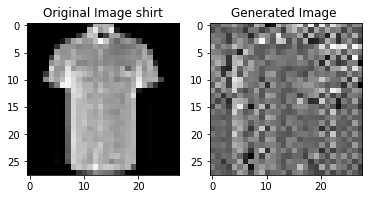

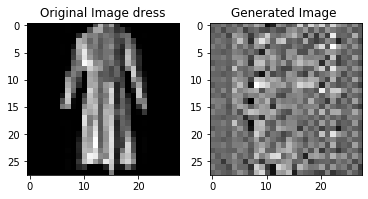

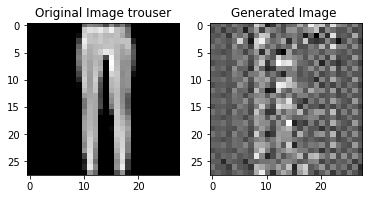

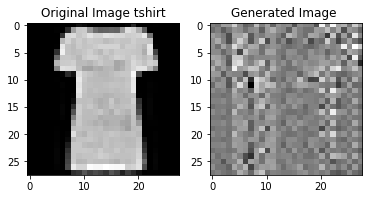

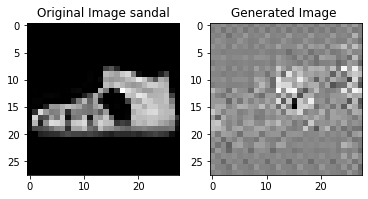

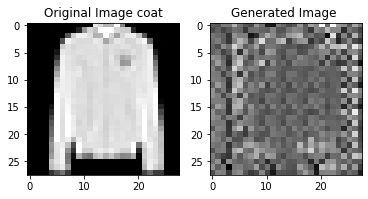

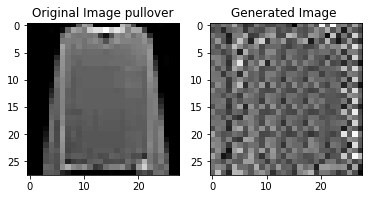

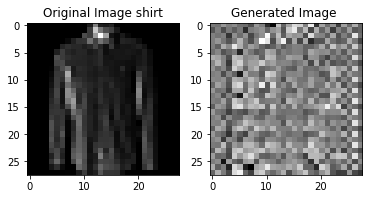

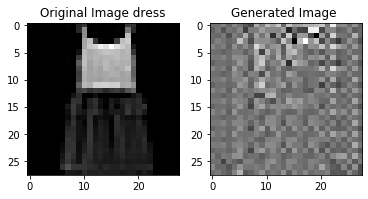

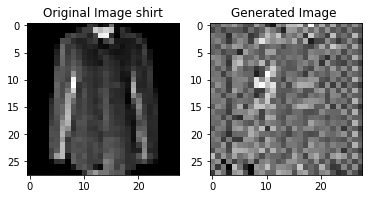

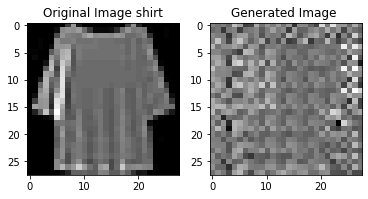

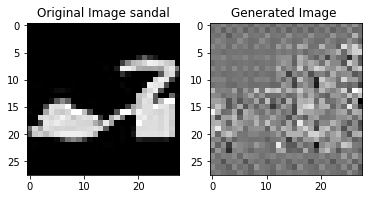

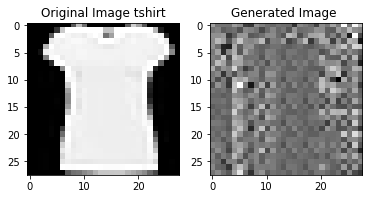

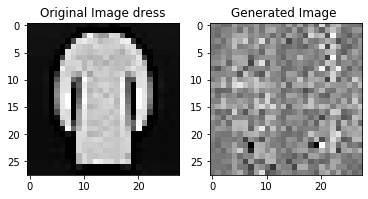

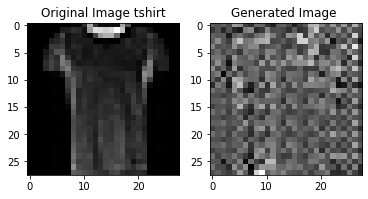

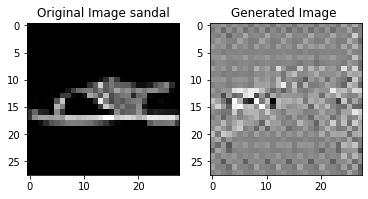

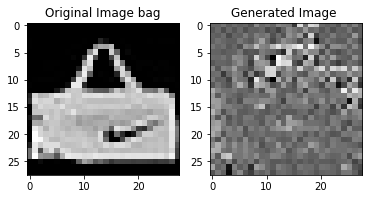

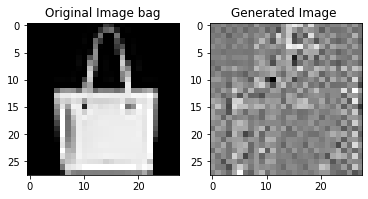

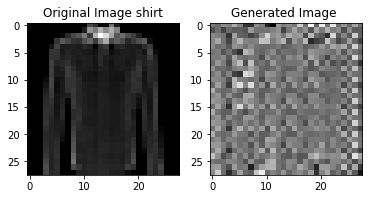

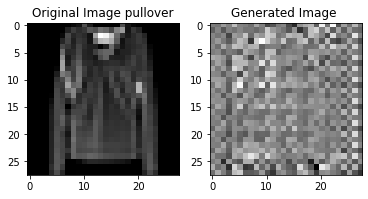

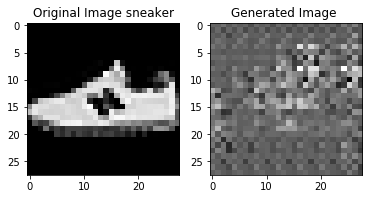

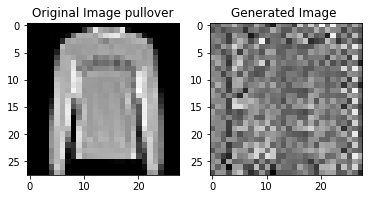

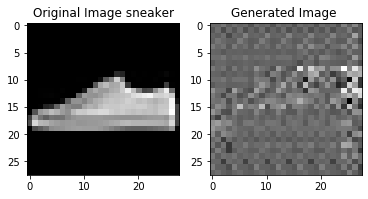

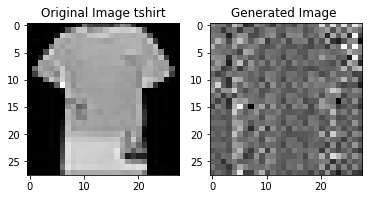

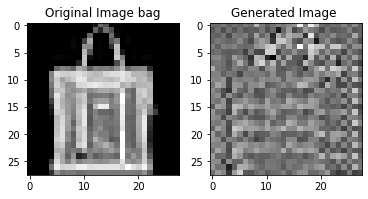

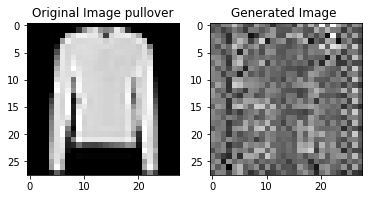

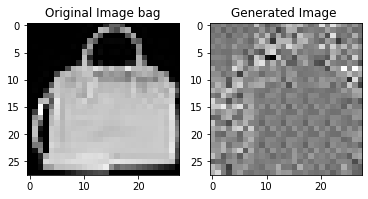

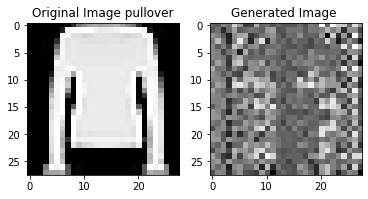

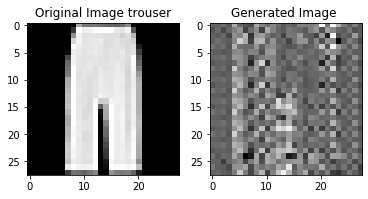

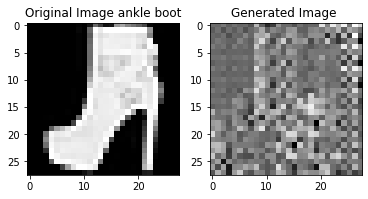

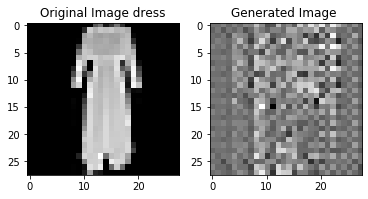

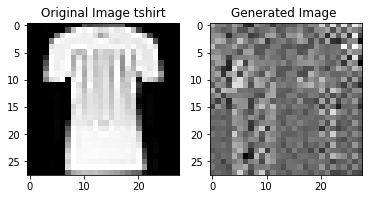

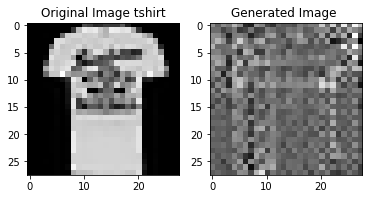

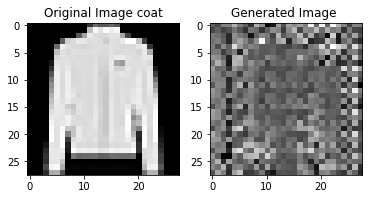

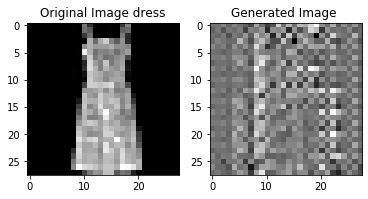

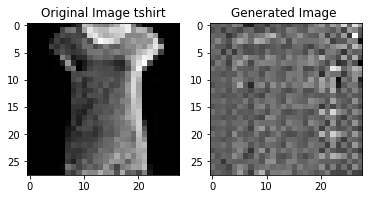

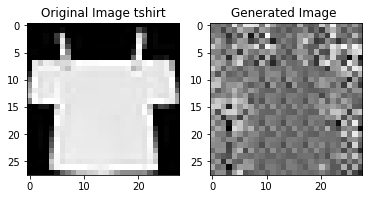

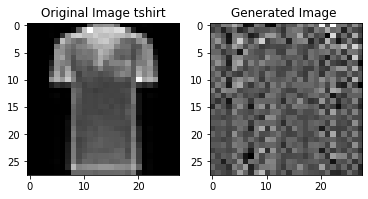

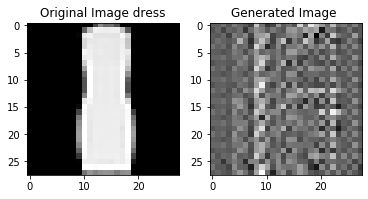

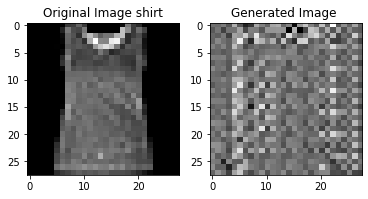

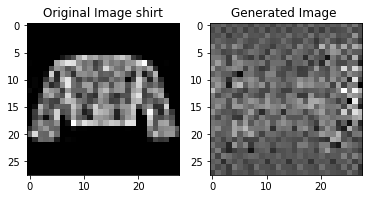

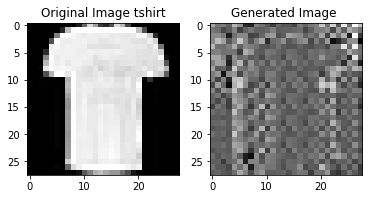

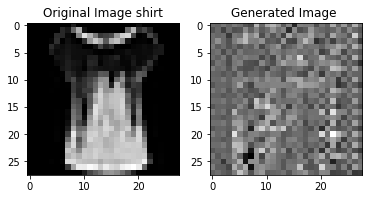

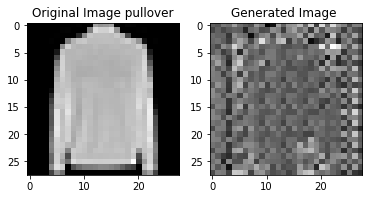

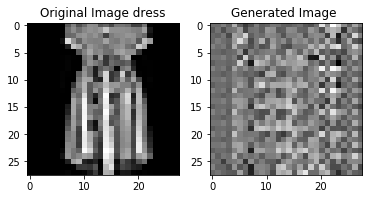

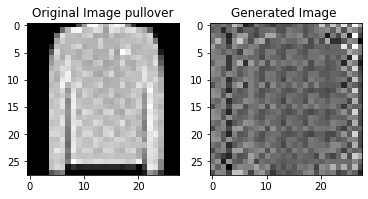

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed (two losses - no scaling of losses)

In [0]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss1 = criterion1(decoded,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader)
    val_loss, val_accuracy = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 0.9647, Training Accuracy: 30491/48000 (64%)
Average test loss: 0.5941, Testing Accuracy: 9545/12000 (80%)
Epoch 1
Average training loss: 0.6050, Training Accuracy: 38001/48000 (79%)
Average test loss: 0.4662, Testing Accuracy: 10256/12000 (85%)
Epoch 2
Average training loss: 0.5404, Training Accuracy: 39468/48000 (82%)
Average test loss: 0.3861, Testing Accuracy: 10475/12000 (87%)
Epoch 3
Average training loss: 0.5224, Training Accuracy: 39862/48000 (83%)
Average test loss: 0.3660, Testing Accuracy: 10472/12000 (87%)
Epoch 4
Average training loss: 0.5023, Training Accuracy: 40146/48000 (84%)
Average test loss: 0.3578, Testing Accuracy: 10537/12000 (88%)
Epoch 5
Average training loss: 0.4823, Training Accuracy: 40545/48000 (84%)
Average test loss: 0.4009, Testing Accuracy: 10338/12000 (86%)
Epoch 6
Average training loss: 0.5068, Training Accuracy: 40260/48000 (84%)
Average test loss: 0.3608, Testing Accuracy: 10642/12000 (89%)
Epoch 7
Average training loss: 0.468

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average test loss: 0.7624, Testing Accuracy: 8629/10000 (86%)
Lowest validation loss 0.3577884113059399


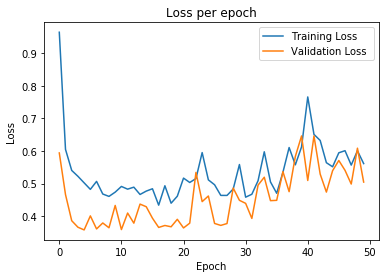

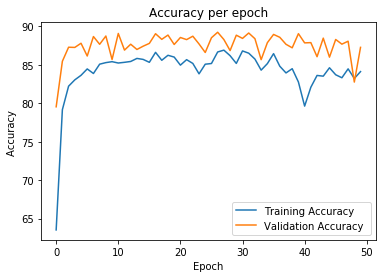

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(training_accuracies,val_accuracies,epochs,"Accuracy ")
test(model,device,testloader)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


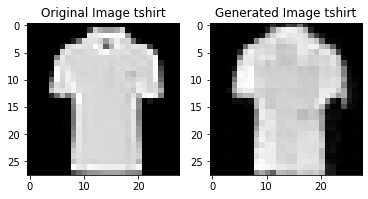

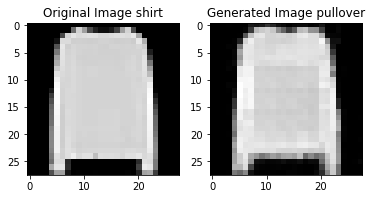

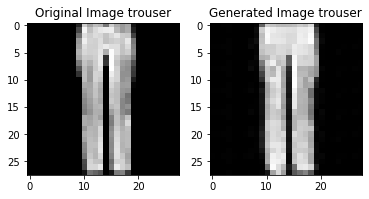

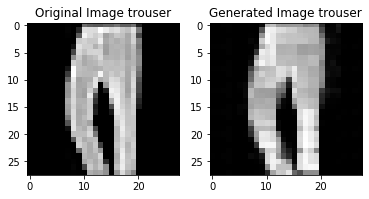

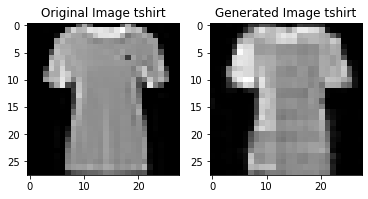

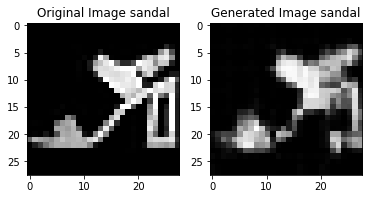

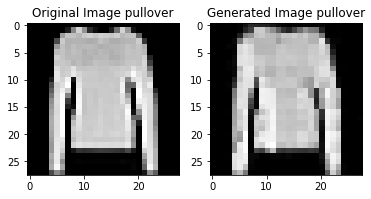

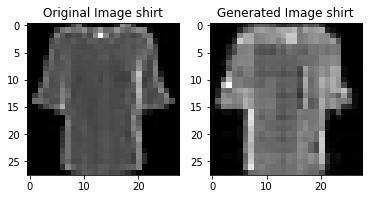

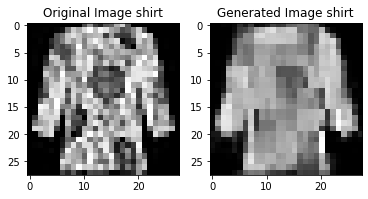

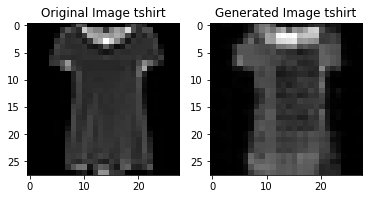

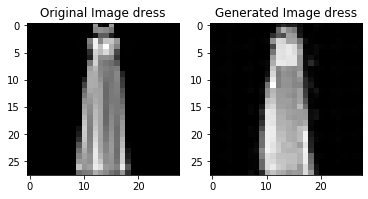

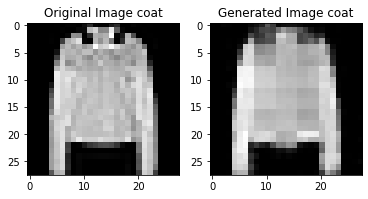

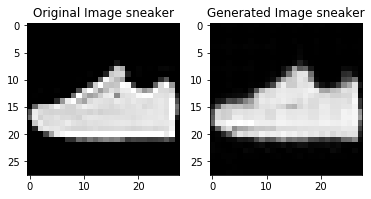

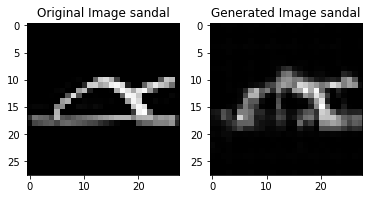

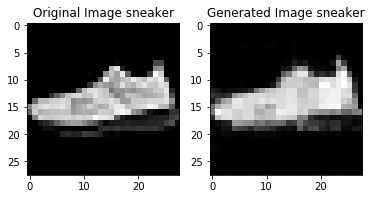

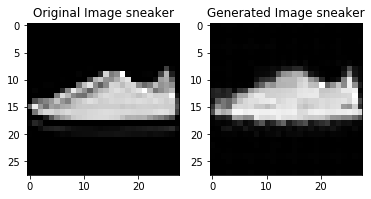

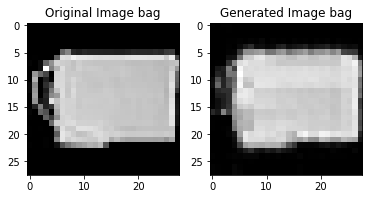

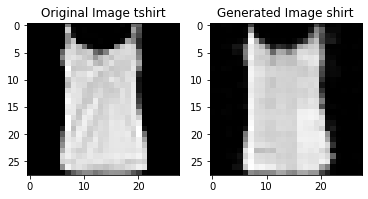

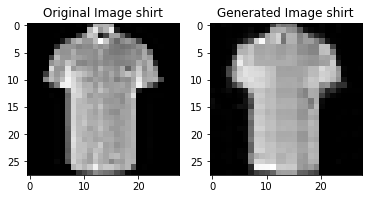

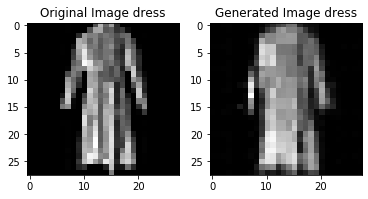

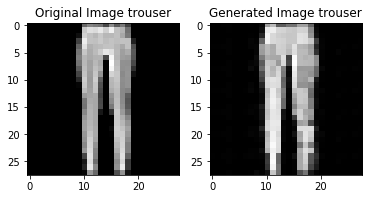

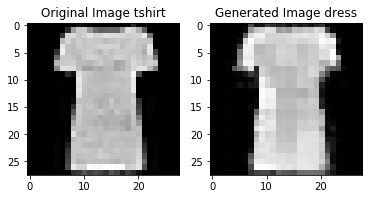

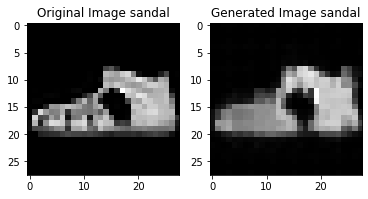

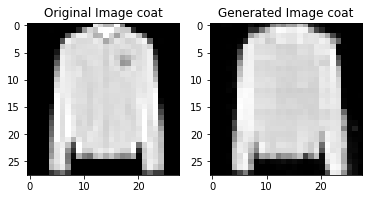

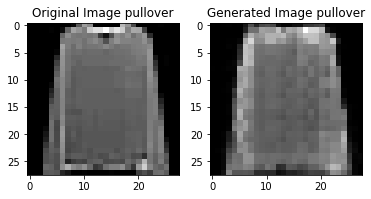

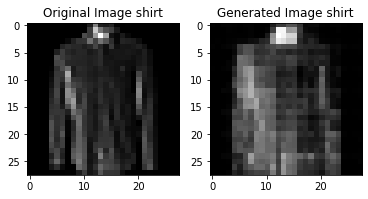

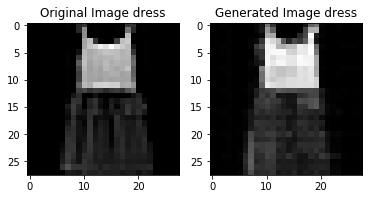

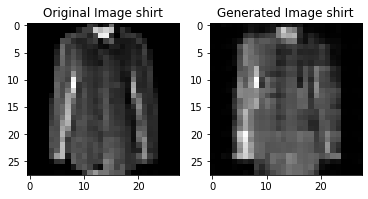

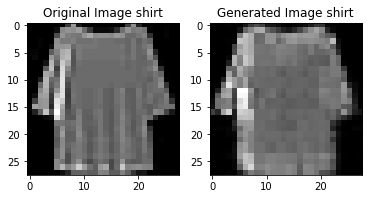

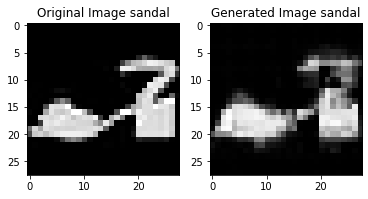

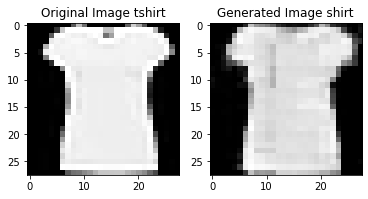

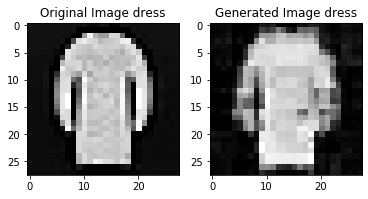

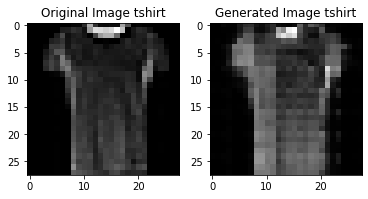

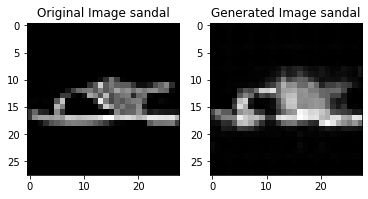

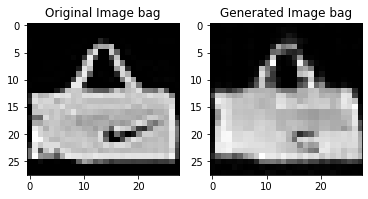

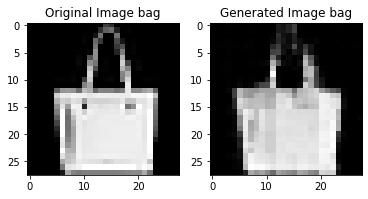

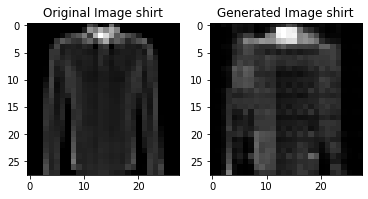

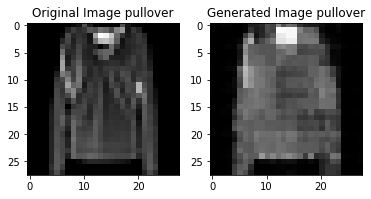

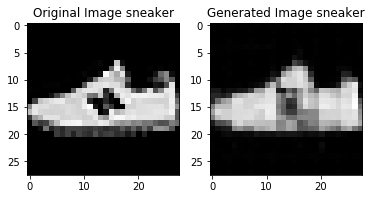

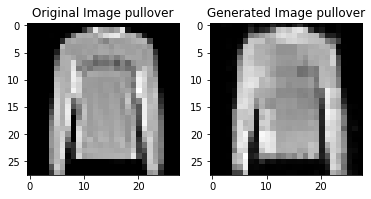

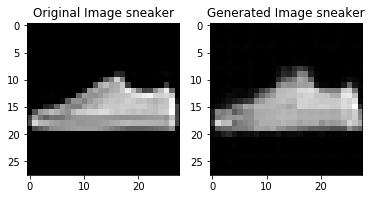

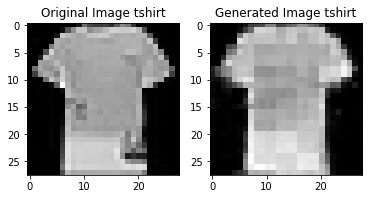

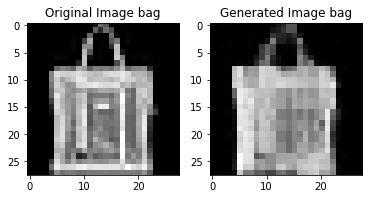

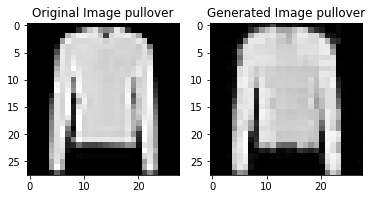

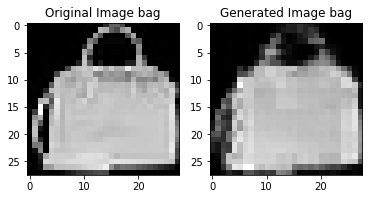

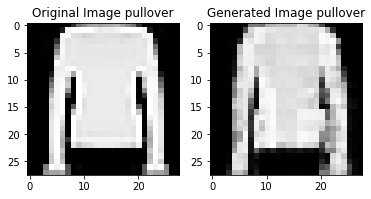

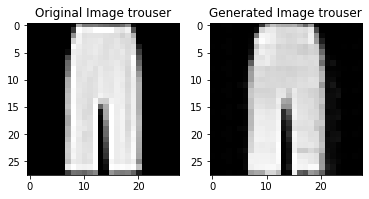

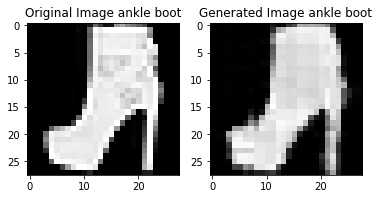

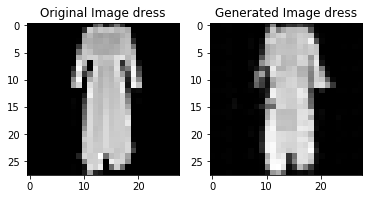

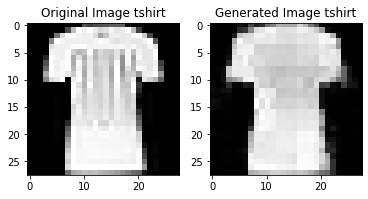

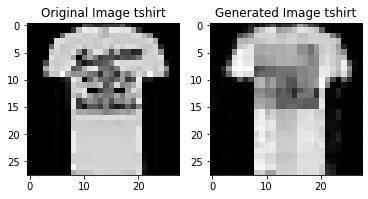

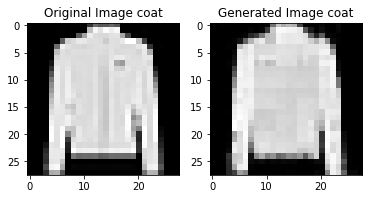

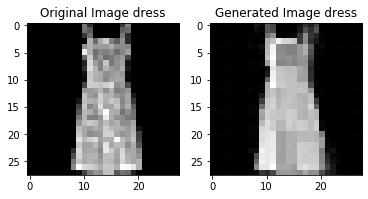

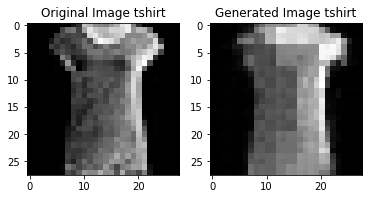

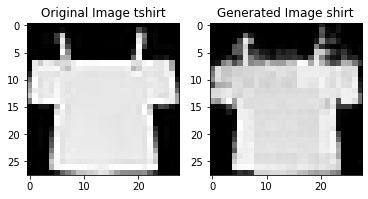

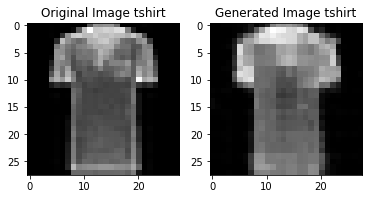

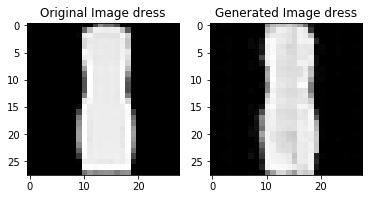

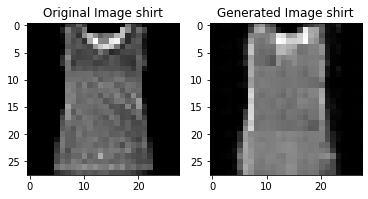

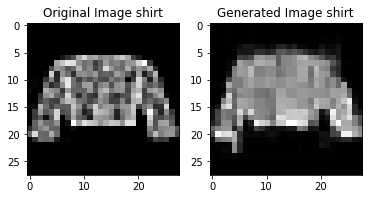

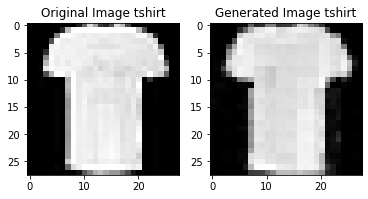

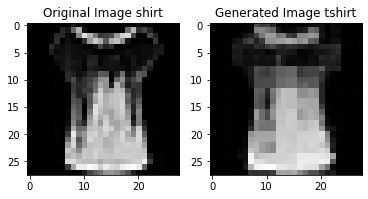

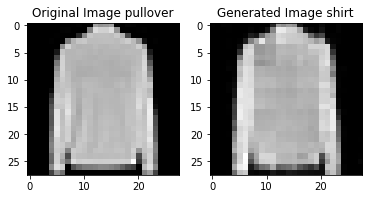

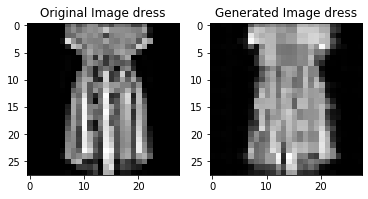

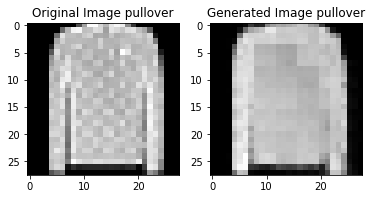

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed model - with scaling of losses

In [0]:
def train(model,device,optimizer,epoch,trainloader,train_auto_mean,train_auto_std,train_class_mean,train_class_std):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss1 = (criterion1(decoded,images)-train_auto_mean)/train_auto_std
        loss2 = (criterion2(predicted,labels)-train_class_mean)/train_class_std
        loss = loss1+loss2
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader,val_auto_mean,val_auto_std,val_class_mean,val_class_std):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss1 = (criterion1(decoded,images)-val_auto_mean)/val_auto_std
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader,train_mean_auto,train_std_auto,train_class_mean,train_class_std)
    val_loss, val_accuracy = test(model,device,valloader,val_mean_auto,val_std_auto,val_class_mean,val_class_std)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 12.6158, Training Accuracy: 34521/48000 (72%)
Average test loss: 3.5186, Testing Accuracy: 9969/12000 (83%)
Epoch 1
Average training loss: 4.0092, Training Accuracy: 38896/48000 (81%)
Average test loss: 2.5535, Testing Accuracy: 10282/12000 (86%)
Epoch 2
Average training loss: 2.7397, Training Accuracy: 40055/48000 (83%)
Average test loss: 2.4784, Testing Accuracy: 10404/12000 (87%)
Epoch 3
Average training loss: 1.9731, Training Accuracy: 40812/48000 (85%)
Average test loss: 1.2601, Testing Accuracy: 10512/12000 (88%)
Epoch 4
Average training loss: 1.8088, Training Accuracy: 41087/48000 (86%)
Average test loss: 0.6840, Testing Accuracy: 10580/12000 (88%)
Epoch 5
Average training loss: 1.7426, Training Accuracy: 41006/48000 (85%)
Average test loss: 2.1911, Testing Accuracy: 10478/12000 (87%)
Epoch 6
Average training loss: 0.9351, Training Accuracy: 41508/48000 (86%)
Average test loss: 1.4896, Testing Accuracy: 10389/12000 (87%)
Epoch 7
Average training loss: 1.14

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average test loss: 0.4513, Testing Accuracy: 8901/10000 (89%)
Lowest validation loss -0.6437982940610419


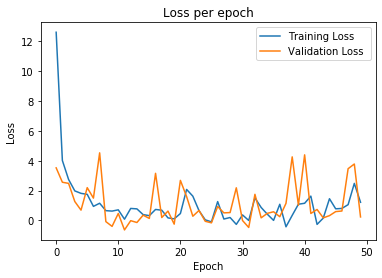

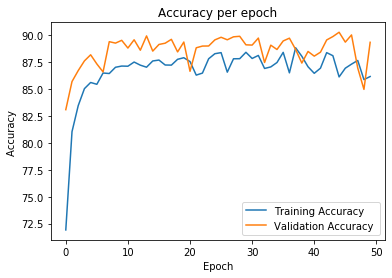

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(training_accuracies,val_accuracies,epochs,"Accuracy ")
test(model,device,testloader,val_mean_auto,val_std_auto,val_class_mean,val_class_std)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


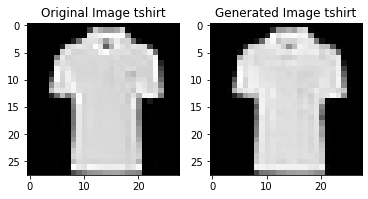

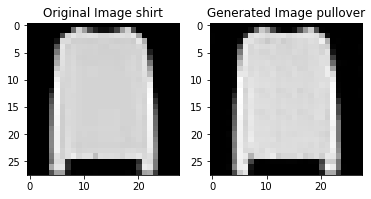

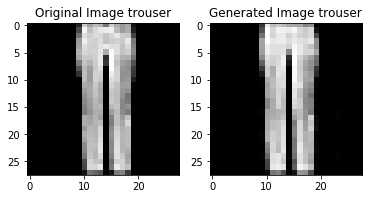

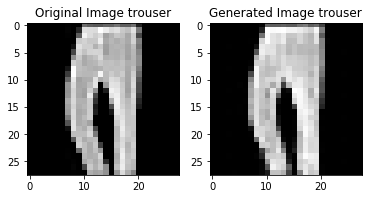

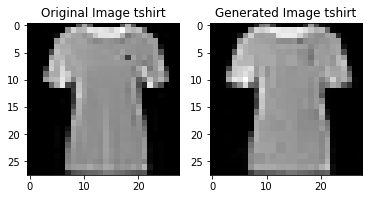

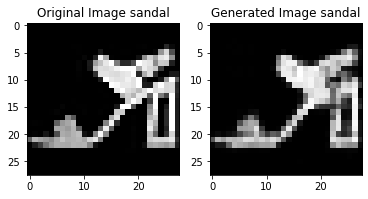

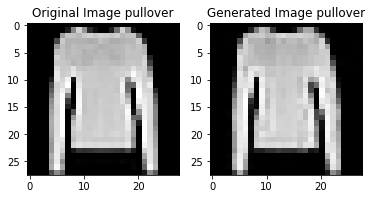

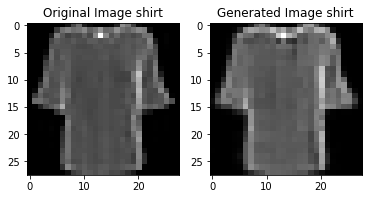

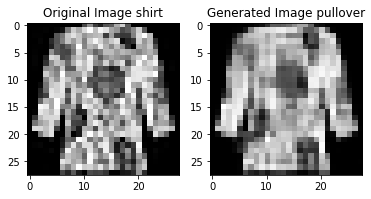

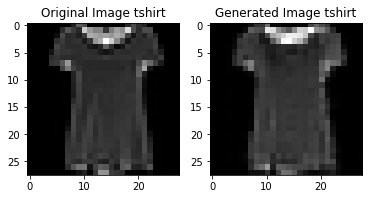

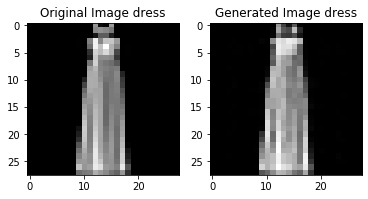

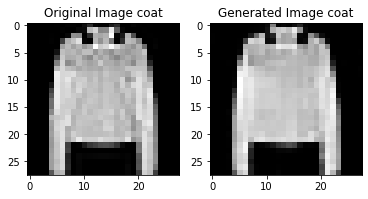

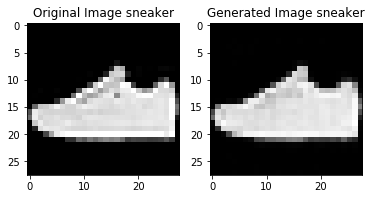

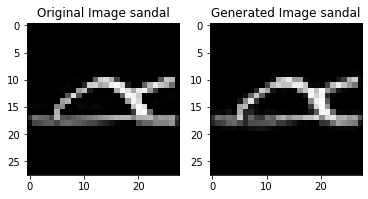

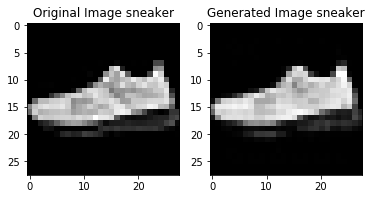

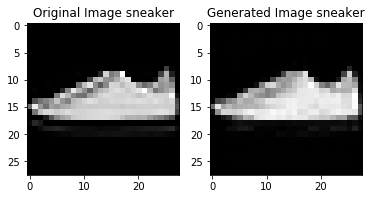

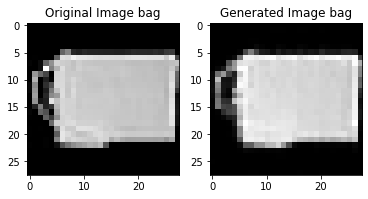

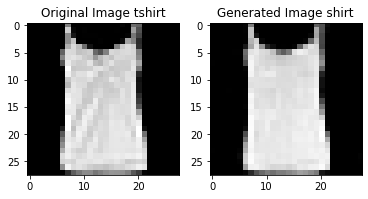

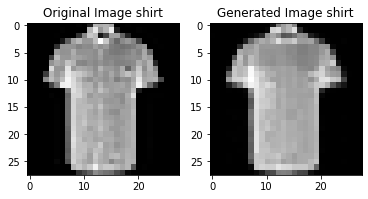

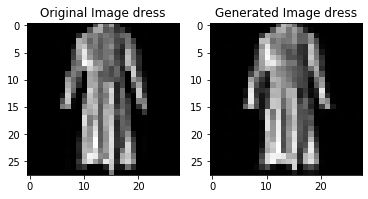

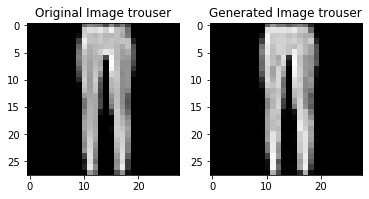

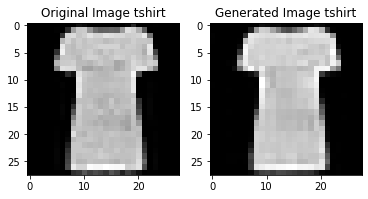

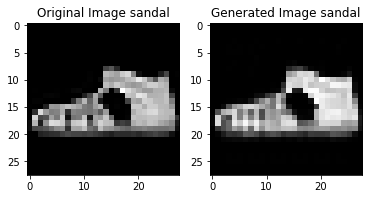

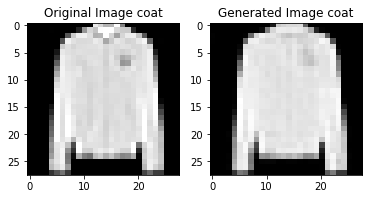

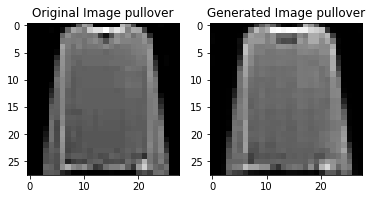

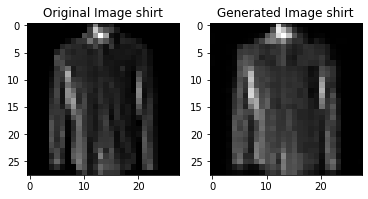

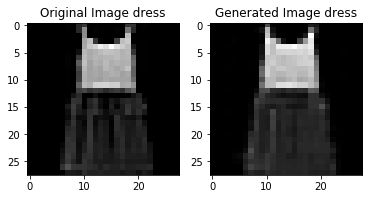

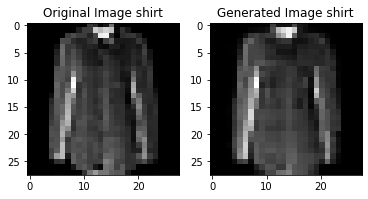

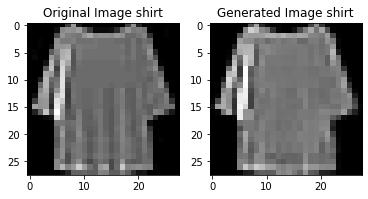

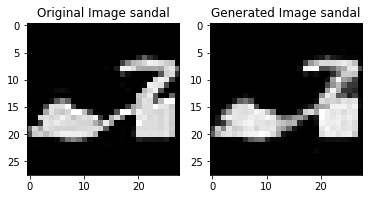

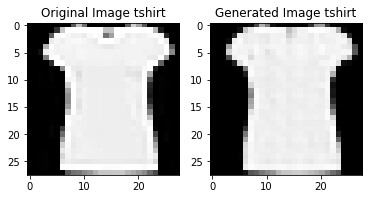

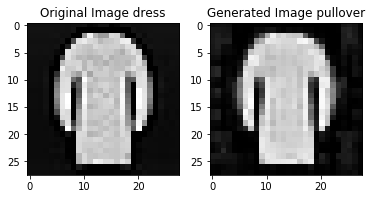

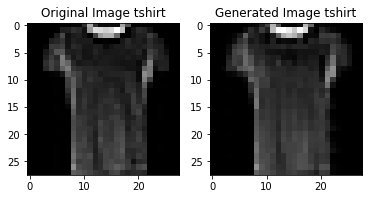

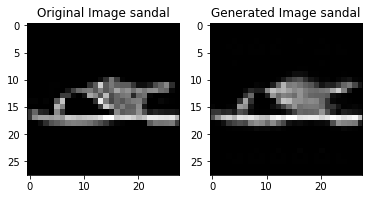

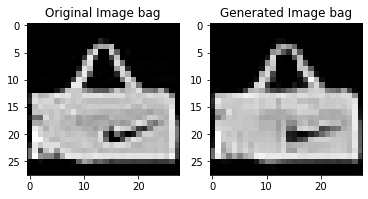

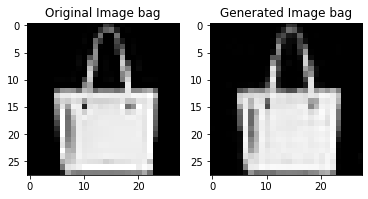

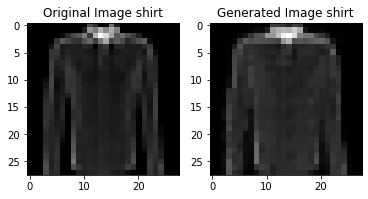

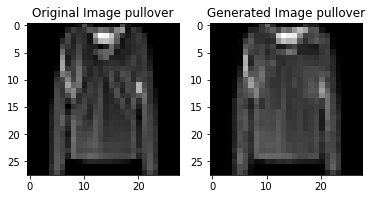

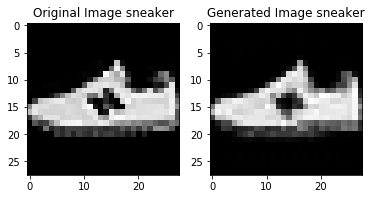

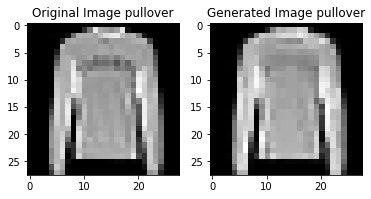

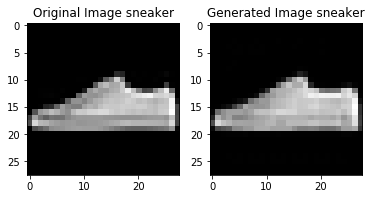

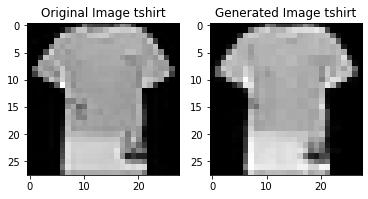

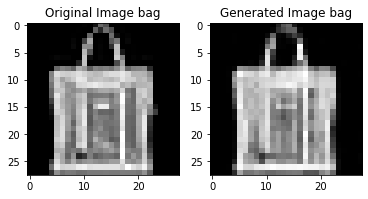

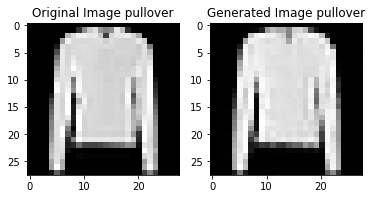

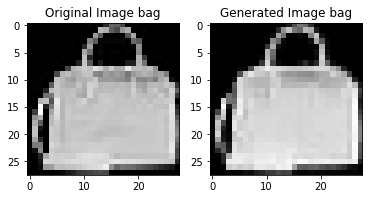

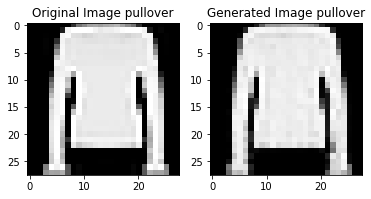

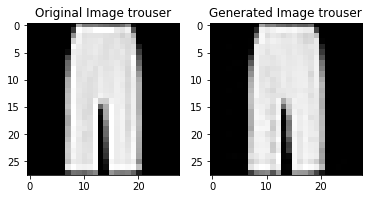

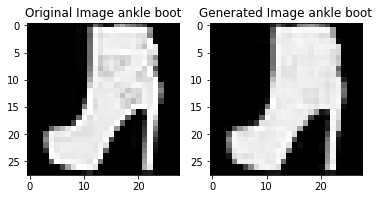

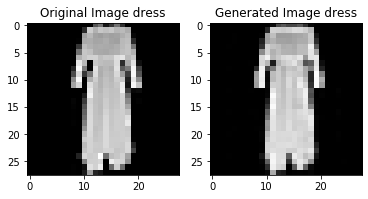

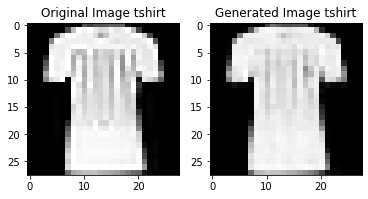

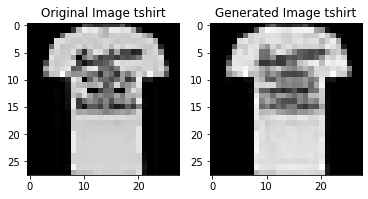

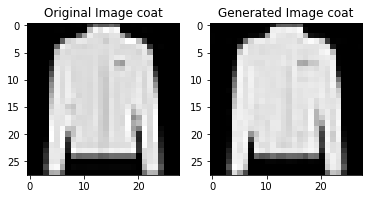

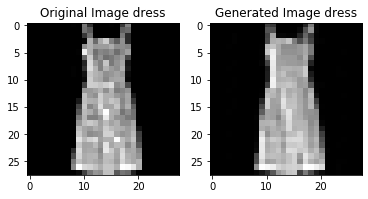

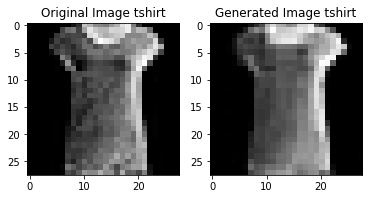

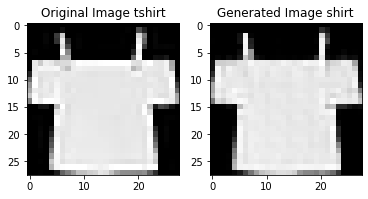

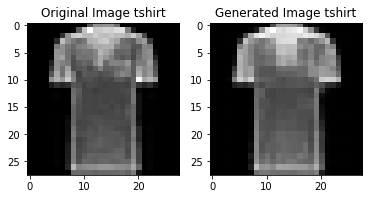

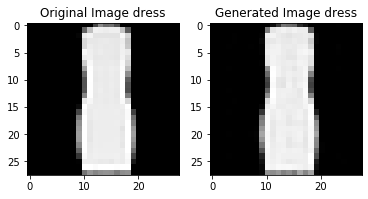

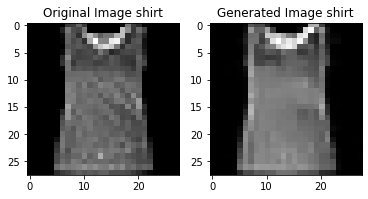

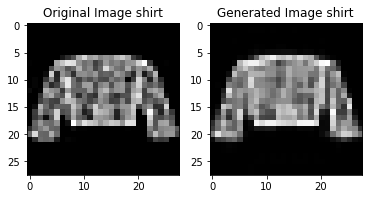

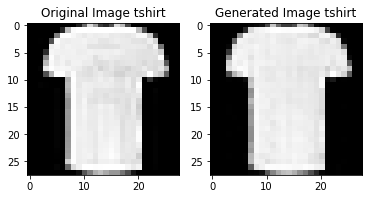

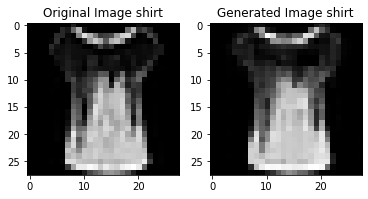

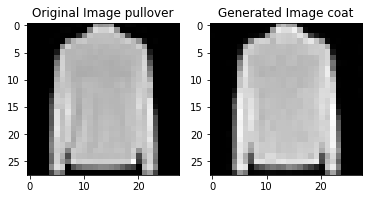

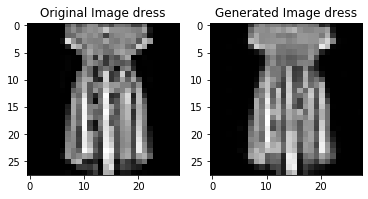

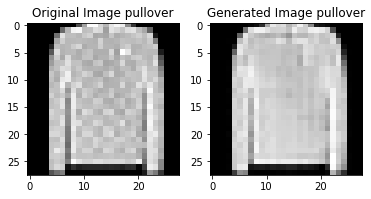

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()